Figuring out how to use PAM

In [322]:
import os
from copy import deepcopy

import acbm

import numpy as np
import pandas as pd
import geopandas as gpd
import pam
from pam.activity import Activity, Leg, Plan
from pam.location import Location
from pam.planner.choice_location import DiscretionaryTripOD, DiscretionaryTrips
from pam.planner.od import ODFactory, ODMatrix
from pam.planner.utils_planner import get_trip_chains_either_anchor
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from prettytable import PrettyTable
from shapely.geometry import Point
from libpysal.weights import Queen


from acbm.preprocessing import nts_filter_by_year, add_location
from acbm.assigning.primary_select import select_facility

pd.set_option('display.max_columns', None)


# Load in the data

In [294]:
activity_chains = pd.read_parquet(
    acbm.root_path / "data/interim/matching/spc_with_nts_trips.parquet"
)
activity_chains = activity_chains[activity_chains["TravDay"] == 3]  # Wednesday


## Add OA21CD to the data

We will use it to select home locations using select_facility()

In [295]:
where_clause = "MSOA21NM LIKE '%Leeds%'"

boundaries = gpd.read_file(
    acbm.root_path / "data/external/boundaries/oa_england.geojson", where=where_clause
)

# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)


# --- Assign activity home locations to boundaries zoning system

# Convert location column in activity_chains to spatial column
centroid_layer = pd.read_csv(
    acbm.root_path / "data/external/centroids/Output_Areas_Dec_2011_PWC_2022.csv"
)
activity_chains = add_location(
    activity_chains, "EPSG:27700", "EPSG:4326", centroid_layer, "OA11CD", "OA11CD"
)

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry="location")
activity_chains.crs = "EPSG:4326"  # I assume this is the crs


# remove index_right column from activity_chains if it exists
if "index_right" in activity_chains.columns:
    activity_chains = activity_chains.drop(columns="index_right")


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(
    activity_chains, boundaries[["OA21CD", "geometry"]], how="left", predicate="within"
)
activity_chains = activity_chains.drop("index_right", axis=1)

2024-08-09 14:39:05,520 - DEBUG - GDAL_DATA found in environment.
2024-08-09 14:39:05,520 - DEBUG - PROJ_DATA found in environment.
2024-08-09 14:39:10,277 - DEBUG - GDAL_DATA found in environment.
2024-08-09 14:39:10,278 - DEBUG - PROJ_DATA found in environment.
2024-08-09 14:39:10,278 - DEBUG - Got coordinate system
2024-08-09 14:39:10,278 - DEBUG - Got coordinate system
2024-08-09 14:39:10,279 - DEBUG - Matched. confidence=100, c_code=b'27700', c_name=b'EPSG'
2024-08-09 14:39:10,279 - DEBUG - OLC_FASTSETNEXTBYINDEX: 0
2024-08-09 14:39:10,280 - DEBUG - OLC_FASTFEATURECOUNT: 0
2024-08-09 14:39:10,280 - DEBUG - Next index: 0
2024-08-09 14:39:10,280 - DEBUG - Next index: 1
2024-08-09 14:39:11,487 - DEBUG - Next index: 2
2024-08-09 14:39:11,488 - DEBUG - Next index: 3
2024-08-09 14:39:11,489 - DEBUG - Next index: 4
2024-08-09 14:39:11,490 - DEBUG - Next index: 5
2024-08-09 14:39:11,491 - DEBUG - Next index: 6
2024-08-09 14:39:11,492 - DEBUG - Next index: 7
2024-08-09 14:39:11,492 - DEBUG

In [296]:
# remove location column
activity_chains = activity_chains.drop(columns="location")

## Primary locations

In [297]:
activity_chains_edu = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_education.pkl"
)

activity_chains_work = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_work.pkl"
)


In [298]:
# get all activity chains where dact is home
activity_chains_home = activity_chains[activity_chains["dact"] == "home"]
# get all activity chains where dact is not work or education
activity_chains_other = activity_chains[
    ~activity_chains["dact"].isin(["work", "education", "home"])
]


In [299]:
# Replace ozone and dzone with Na in activity_chains_other. They are incorrect and will be populated later
activity_chains_other.loc[:, ["ozone", "dzone"]] = np.nan
activity_chains_other.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,E00059031
6,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,escort,5.0,765.0,840.0,1.0,1.0,75.0,45.0,NaN,NaN,0.646775,1.138030,E00059031
12,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002995,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,5.0,car,home,escort,5.0,400.0,401.0,0.3,0.3,1.0,1.0,NaN,NaN,0.961816,1.138030,E00059045
14,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002995,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,work,escort,5.0,1300.0,1322.0,13.0,13.0,22.0,22.0,NaN,NaN,0.961816,1.138030,E00059045
16,425,197,2901553,E02002330,E00059023,"[425, 426]",C,29.0,6,NaN,NaN,E02002330_0198,1.0,NaN,6.0,True,1.0,1,1,59,1,2.0,0.000000,1,1,1,0,1,0,0,0,0,1,E00059023,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001746.0, 2019001081.0, 2019001177.0, 201...",8,2022004472,education_university,2.022050e+09,2.022027e+09,2.022004e+09,2.022002e+09,2.022000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,other,7.0,540.0,554.0,2.7,2.7,14.0,14.0,NaN,NaN,1.356007,1.003426,E00059023
18,425,197,2901553,E02002330,E00059023,"[425, 426]",C,29.0,6,NaN,NaN,E02002330_0198,1.0,NaN,6.0,True,1.0,1,1,59,1,2.0,0.000000,1,1,1,0,1,0,0,0,0,1,E00059023,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001746.0, 2019001081.0, 2

In [300]:
(activity_chains.shape[0], 
 activity_chains_edu.shape[0], 
 activity_chains_work.shape[0], 
 activity_chains_home.shape[0], 
 activity_chains_other.shape[0])

(15811, 411, 1806, 6849, 6745)

In [301]:
activity_chains["dact"].value_counts()

dact
home         6849
other        2621
work         1806
escort       1762
shop         1281
visit         896
education     411
medical       185
Name: count, dtype: int64

# Add home locations


In [302]:
# osm data
osm_data_gdf = gpd.read_parquet(
    acbm.root_path / "data/external/boundaries/west-yorkshire_epsg_4326.parquet"
)

# get rows in osm_data_gdf where activities includes home

osm_data_gdf = osm_data_gdf[osm_data_gdf["activities"].str.contains("home")]
osm_data_gdf

# spatial join to identify which zone each point in osm_data is in
osm_data_gdf = gpd.sjoin(
    osm_data_gdf, boundaries[["OA21CD", "geometry"]], how="inner", predicate="within"
)

osm_data_gdf.head(10)

,id,activities,geometry,units,levels,area,floor_area,distance_to_nearest_transit,distance_to_nearest_shop,distance_to_nearest_medical,index_right,OA21CD
1,20621535,home,POINT (-1.56566 53.81375),1.0,2.0,0,0.0,198.493258,108.072976,255.853754,851,E00057657
2,21591858,home,POINT (-1.63279 53.87138),1.0,2.0,0,0.0,969.484065,509.809989,2318.285507,557,E00057349
5,27411630,home,POINT (-1.72353 53.90655),1.0,2.0,0,0.0,216.265895,986.041911,1716.667311,1524,E00058367
7,27470976,home,POINT (-1.56251 53.90203),1.0,2.0,0,0.0,873.984192,1799.502624,3250.842461,1478,E00058319
117,243857658,home,POINT (-1.58420 53.82091),1.0,2.0,0,0.0,254.519273,207.974705,391.618763,834,E00057637
215,263905389,home,POINT (-1.58480 53.83411),1.0,2.0,0,0.0,18.165010,538.231938,947.117436,2070,E00058957
233,266347353,home,POINT (-1.59132 53.86960),1.0,2.0,0,0.0,239.833745,330.022370,1799.256632,2475,E00170889
436,297118275,home,POINT (-1.65174 53.79927),1.0,2.0,0,0.0,78.022954,40.506960,23.413135,1632,E00058477
549,304609832,home,POINT (-1.62587 53.80985),1.0,2.0,0,0.0,46.651413,103.570196,161.971263,144,E00056906
623,317087655,home,POINT (-1.53952 53.79314),1.0,2.0,0,0.0,198.799706,55.563040,250.884104,2482,E00187029


## Calculate a home location only once per household

In [303]:
# Keep one row per household and select only household and OA21CD columns
activity_chains_home_hh = activity_chains_home.drop_duplicates(subset=["household"])
activity_chains_home_hh = activity_chains_home_hh[["household", "dact", "OA21CD"]]

In [304]:
activity_chains_home_hh

,household,dact,OA21CD
1,89,home,E00059031
11,139,home,E00059045
17,197,home,E00059023
21,283,home,E00059012
38,342,home,E00059033
...,...,...,...
15790,334049,home,E00187098
15792,334172,home,E00057789
15794,334223,home,E00170040
15799,334249,home,E00170267


## Get the home location

In [305]:
zone_neighbors = Queen.from_dataframe(boundaries, ids="OA21CD").neighbors


In [306]:
# apply the function to a row in activity_chains_ex
activity_chains_home_hh[["activity_id", "activity_geom"]] = activity_chains_home_hh.apply(
    lambda row: select_facility(
        row=row,
        facilities_gdf=osm_data_gdf,
        row_destination_zone_col="OA21CD",
        row_activity_type_col="dact",
        gdf_facility_zone_col="OA21CD",
        gdf_facility_type_col="activities",
        gdf_sample_col="floor_area",
        #neighboring_zones=zone_neighbors,
    ),
    axis=1,
)

2024-08-09 14:39:24,199 - assigning_primary_locations - INFO - Activity 1: Found 182 matching facilities in zone E00059031
2024-08-09 14:39:24,199 - INFO - Activity 1: Found 182 matching facilities in zone E00059031
2024-08-09 14:39:24,203 - assigning_primary_locations - INFO - Activity 1: Sampled facility based on floor area)
2024-08-09 14:39:24,203 - INFO - Activity 1: Sampled facility based on floor area)
2024-08-09 14:39:24,218 - assigning_primary_locations - INFO - Activity 11: Found 124 matching facilities in zone E00059045
2024-08-09 14:39:24,218 - INFO - Activity 11: Found 124 matching facilities in zone E00059045
2024-08-09 14:39:24,222 - assigning_primary_locations - INFO - Activity 11: Sampled facility based on floor area)
2024-08-09 14:39:24,222 - INFO - Activity 11: Sampled facility based on floor area)
2024-08-09 14:39:24,240 - assigning_primary_locations - INFO - Activity 17: Found 124 matching facilities in zone E00059023
2024-08-09 14:39:24,240 - INFO - Activity 17: Fo

In [307]:
activity_chains_home_hh.head(5)

,household,dact,OA21CD,activity_id,activity_geom
1,89,home,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
11,139,home,E00059045,1750466182,POINT (-1.401353990465715 53.92843708116359)
17,197,home,E00059023,1730050360,POINT (-1.392913905161609 53.93974658654156)
21,283,home,E00059012,1786588190,POINT (-1.386726962953223 53.94095373791892)
38,342,home,E00059033,1685619030,POINT (-1.405355586291493 53.93379819463803)


## Merge home locations back onto activity_chains_home

In [308]:
# join activity_chains_home_hh onto activity_chains_home based on household column
activity_chains_home = activity_chains_home.merge(
    activity_chains_home_hh[["household", "activity_id", "activity_geom"]],
    on="household",
    how="left",
)

activity_chains_home.head(5)


,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,2.0,0.568328,1.000000,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
3,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,escort,home,5.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,2.0,0.646775,1.138030,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
4,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,2.0,2.0,1.0,7.0,car,medical,home,6.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,2.0,0.646775,1.138030,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)


In [309]:
# replace dzone column with OA21CD
activity_chains_home["dzone"] = activity_chains_home["OA21CD"]
activity_chains_home.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,E00059031,0.568328,1.000000,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
3,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,escort,home,5.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,E00059031,0.646775,1.138030,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
4,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,2.0,2.0,1.0,7.0,car,medical,home,6.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,E00059031,0.646775,1.138030,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366)
5,312,139,2911320,E02002330,E00059045,"[312, 313]",Q,86.0,6,NaN,NaN,E02002330_0140,1.0,NaN,6.0,True,1.0,1,2,64,1,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002994,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,7.0,ca

# Combine all dataframes

In [351]:
# merge the three dataframes
activity_chains_all = pd.concat([activity_chains_edu, 
                                 activity_chains_work, 
                                 activity_chains_home,
                                 activity_chains_other])
# sort by houshold_id, individual_id, and sequence
activity_chains_all = activity_chains_all.sort_values(by=["household", "id", "seq"])
activity_chains_all.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,activity_id,activity_geom,hzone
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,None,E00059031,NaN,NaN,NaN
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,None,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366),E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,None,E00059031,NaN,NaN,NaN
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,None,E00059031,1735591092,POINT (-1.396271936934464 53.93449174748366),E00059031
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,E00058564,0.568328,1.000000,None,NaN,1955094120,POINT (-1.49656225379334 53.78439183373149),NaN
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2

In [352]:
import numpy as np

# Step 1: Create dictionaries to map each id to their activity_geom, activity_id, and dzone for each activity type
activity_types = ["home", "education", "work"]
activity_geom_dict = {}
activity_id_dict = {}
dzone_dict = {}

for activity in activity_types:
    filtered_df = activity_chains_all[
        (activity_chains_all["dact"] == activity) & (activity_chains_all["activity_geom"].notnull())
    ]
    activity_geom_dict[activity] = filtered_df.set_index("id")["activity_geom"].to_dict()
    activity_id_dict[activity] = filtered_df.set_index("id")["activity_id"].to_dict()
    dzone_dict[activity] = filtered_df.set_index("id")["dzone"].to_dict()

# Step 2: Populate the origin_geom, origin_id, and ozone columns based on the oact value
def get_origin_geom(row):
    if row["oact"] in activity_geom_dict and row["id"] in activity_geom_dict[row["oact"]]:
        return activity_geom_dict[row["oact"]][row["id"]]
    return None

def get_origin_id(row):
    if row["oact"] in activity_id_dict and row["id"] in activity_id_dict[row["oact"]]:
        return activity_id_dict[row["oact"]][row["id"]]
    return None

def get_ozone(row):
    if row["oact"] in dzone_dict and row["id"] in dzone_dict[row["oact"]]:
        return dzone_dict[row["oact"]][row["id"]]
    return np.nan

activity_chains_all = activity_chains_all.copy()
activity_chains_all["origin_geom"] = activity_chains_all.apply(get_origin_geom, axis=1)
activity_chains_all["origin_id"] = activity_chains_all.apply(get_origin_id, axis=1)
activity_chains_all["ozone"] = activity_chains_all.apply(get_ozone, axis=1)

In [353]:
activity_chains_all = activity_chains_all[["id", "household", "nts_ind_id", "nts_hh_id", "age_years", 
                                           "oact", "dact", "TripTotalTime", "TripDisIncSW", "seq", "mode", "tst", "tet", 
                                           "ozone", "dzone", "origin_id", "origin_geom", "activity_id", "activity_geom"]]

activity_chains_all.head(10)

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,origin_id,origin_geom,activity_id,activity_geom
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,1735591092,POINT (-1.39627 53.93449),NaN,NaN
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,NaN,E00059031,None,None,1735591092,POINT (-1.396271936934464 53.93449174748366)
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,1735591092,POINT (-1.39627 53.93449),NaN,NaN
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,NaN,E00059031,None,None,1735591092,POINT (-1.396271936934464 53.93449174748366)
10,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,1735591092,POINT (-1.39627 53.93449),1955094120,POINT (-1.49656225379334 53.78439183373149)
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,work,home,30.0,13.0,6.0,car,1230.0,1260.0,E00058564,E00059031,1955094120,POINT (-1.49656 53.78439),1735591092,POINT (-1.396271936934464 53.93449174748366)
6,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,home,escort,75.0,1.0,1.0,car,765.0,840.0,E00059031,NaN,1735591092,POINT (-1.39627 53.93449),NaN,NaN
3,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,escort,home,20.0,1.0,2.0,car,930.0,950.0,NaN,E00059031,None,None,1735591092,POINT (-1.396271936934464 53.93449174748366)
0,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,home,education,5.0,1.0,1.0,car,520.0,525.0,E00059031,E00059030,1735591092,POINT (-1.39627 53.93449),160360912,POINT (-1.390539537152311 53.93323059983641)
4,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,medical,home,20.0,1.0,2.0,car,930.0,950.0,NaN,E00059031,None,None,1735591092,POINT (-1.396271936934464 53.93449174748366)


### PAM needs a hzone column. Add it

In [356]:

# Merge the DataFrames on 'household_id' from activity_chains and 'house_id' from activity_chains_home_hh
activity_chains_all = activity_chains_all.merge(activity_chains_home_hh[['household', 'OA21CD']], on='household', how ='left')

# Rename the 'OA21CD' column to 'hzone'
activity_chains_all.rename(columns={'OA21CD': 'hzone'}, inplace=True)

activity_chains_all.head(5)

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,origin_id,origin_geom,activity_id,activity_geom,hzone
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,1735591092,POINT (-1.39627 53.93449),NaN,NaN,E00059031
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,NaN,E00059031,None,None,1735591092,POINT (-1.396271936934464 53.93449174748366),E00059031
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,1735591092,POINT (-1.39627 53.93449),NaN,NaN,E00059031
3,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,NaN,E00059031,None,None,1735591092,POINT (-1.396271936934464 53.93449174748366),E00059031
4,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,1735591092,POINT (-1.39627 53.93449),1955094120,POINT (-1.49656225379334 53.78439183373149),E00059031


# Prepare data fro PAM 

## Individuals

In [357]:
individuals = activity_chains_all[['id', 'household', 'age_years']].drop_duplicates(subset=['id'])

# rename columns
individuals = individuals.rename(columns={"id": "pid", "household": "hid"})
individuals.head(10)

,pid,hid,age_years
0,199,89,39
6,200,89,38
8,201,89,7
10,312,139,64
12,313,139,64
16,425,197,59
20,610,283,67
23,611,283,64
31,612,283,8
35,613,283,2


## Households

## Trips 

In [358]:
trips = activity_chains_all[['id', 'household', 'seq', 'hzone', 'ozone', 'dzone', 'dact', 'mode', 'tst', 'tet']]

# rename columns
trips = trips.rename(columns={"id": "pid", "household": "hid", "dact": "purp"})

# Drop NA values in tst and tet columns and convert to int
trips = trips.dropna(subset=['tst', 'tet'])
trips['tst'] = trips['tst'].astype(int)
trips['tet'] = trips['tet'].astype(int)

trips.head(10)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet
0,199,89,1.0,E00059031,E00059031,NaN,other,walk,600,645
1,199,89,2.0,E00059031,NaN,E00059031,home,walk,645,690
2,199,89,3.0,E00059031,E00059031,NaN,shop,car,720,730
3,199,89,4.0,E00059031,NaN,E00059031,home,car,765,775
4,199,89,5.0,E00059031,E00059031,E00058564,work,car,810,830
5,199,89,6.0,E00059031,E00058564,E00059031,home,car,1230,1260
6,200,89,1.0,E00059031,E00059031,NaN,escort,car,765,840
7,200,89,2.0,E00059031,NaN,E00059031,home,car,930,950
8,201,89,1.0,E00059031,E00059031,E00059030,education,car,520,525
9,201,89,2.0,E00059031,NaN,E00059031,home,car,930,950


In [359]:
# replace Nan values in ozone and dzone with "na"
trips['ozone'] = trips['ozone'].apply(lambda x: None if pd.isna(x) else x)
trips['dzone'] = trips['dzone'].apply(lambda x: None if pd.isna(x) else x)
trips.head(100)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet
0,199,89,1.0,E00059031,E00059031,None,other,walk,600,645
1,199,89,2.0,E00059031,None,E00059031,home,walk,645,690
2,199,89,3.0,E00059031,E00059031,None,shop,car,720,730
3,199,89,4.0,E00059031,None,E00059031,home,car,765,775
4,199,89,5.0,E00059031,E00059031,E00058564,work,car,810,830
...,...,...,...,...,...,...,...,...,...,...
99,3860,1773,2.0,E00059024,E00169780,E00059024,home,car,1110,1140
100,3912,1798,1.0,E00059032,E00059032,None,visit,car,620,635
101,3912,1798,2.0,E00059032,None,None,shop,car,860,890
102,3912,1798,3.0,E00059032,None,E00059032,home,car,890,895


## Read population 

tour_based = False assumes all trips start from home - this is ok for matsim 
see here https://arup-group.github.io/pam/latest/reference/pam/read/diary/#pam.read.diary.load_travel_diary


In [365]:
population = pam.read.load_travel_diary(
    trips = trips,
    persons_attributes = individuals,
    tour_based = False
    #hhs_attributes = None,
    )



2024-08-09 15:52:20,812 - WARNING - 
Using simple trip based purpose parser, this assumes first activity is 'home'.
If you do not wish to assume this, try setting 'tour_based' = True (default).

2024-08-09 15:52:20,812 - DEBUG - Resetting trips index if required
2024-08-09 15:52:20,813 - DEBUG - Setting persons_attributes index to pid
2024-08-09 15:52:20,815 - DEBUG - Initiating trip-based parser.
2024-08-09 15:52:20,820 - INFO - Adding hhs from persons_attributes
2024-08-09 15:52:20,888 - INFO - Adding hhs from trips
2024-08-09 15:52:20,969 - INFO - Adding persons from persons_attributes
2024-08-09 15:52:21,029 - INFO - Adding persons from trips
2024-08-09 15:52:21,346 - DEBUG -  stay_at_home, location:E00056794
2024-08-09 15:52:21,432 - DEBUG -  stay_at_home, location:nan
2024-08-09 15:52:21,581 - DEBUG -  stay_at_home, location:E00057360
2024-08-09 15:52:21,590 - DEBUG -  stay_at_home, location:nan
2024-08-09 15:52:21,591 - DEBUG -  stay_at_home, location:nan
2024-08-09 15:52:21,591

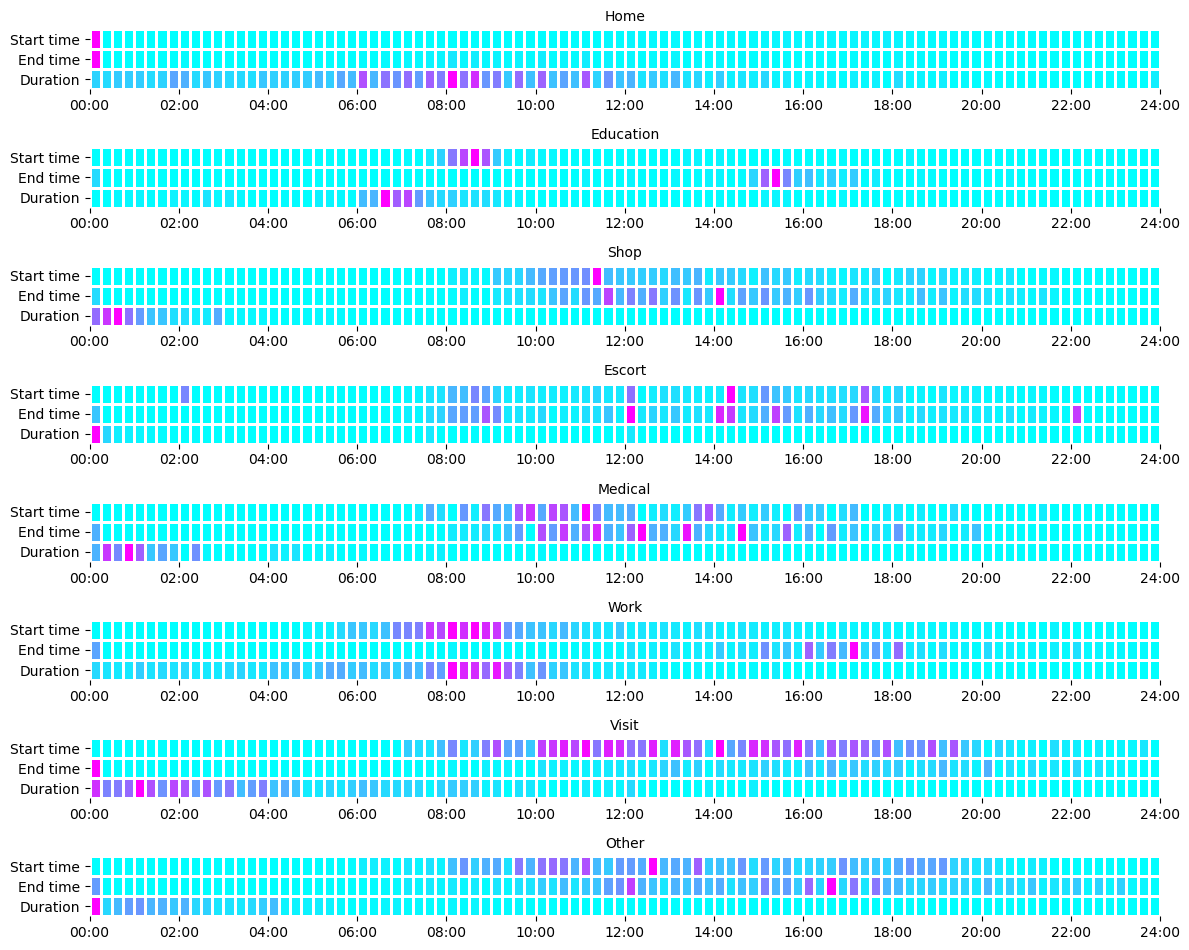

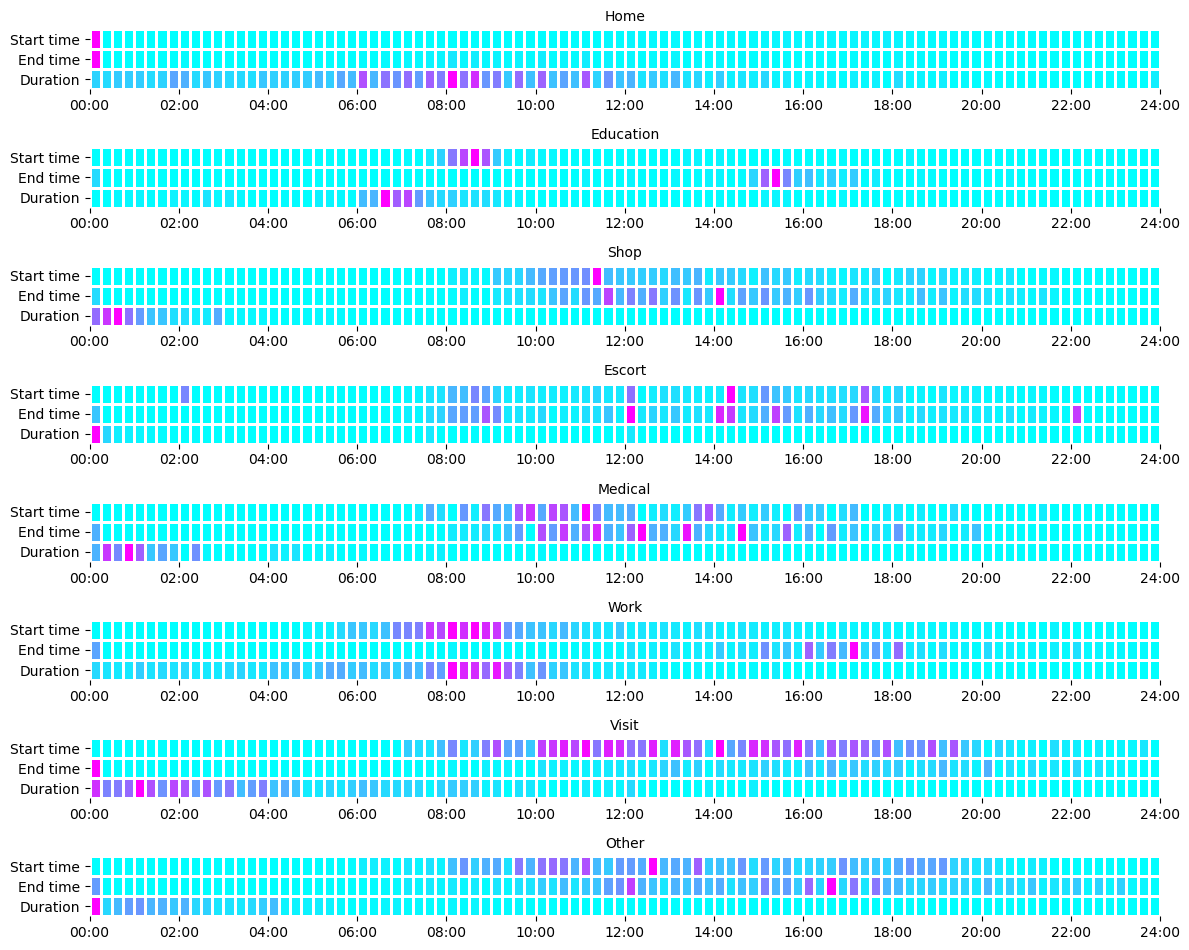

In [370]:
from pam.plot.stats import plot_activity_times, plot_leg_times

plot_activity_times(population)

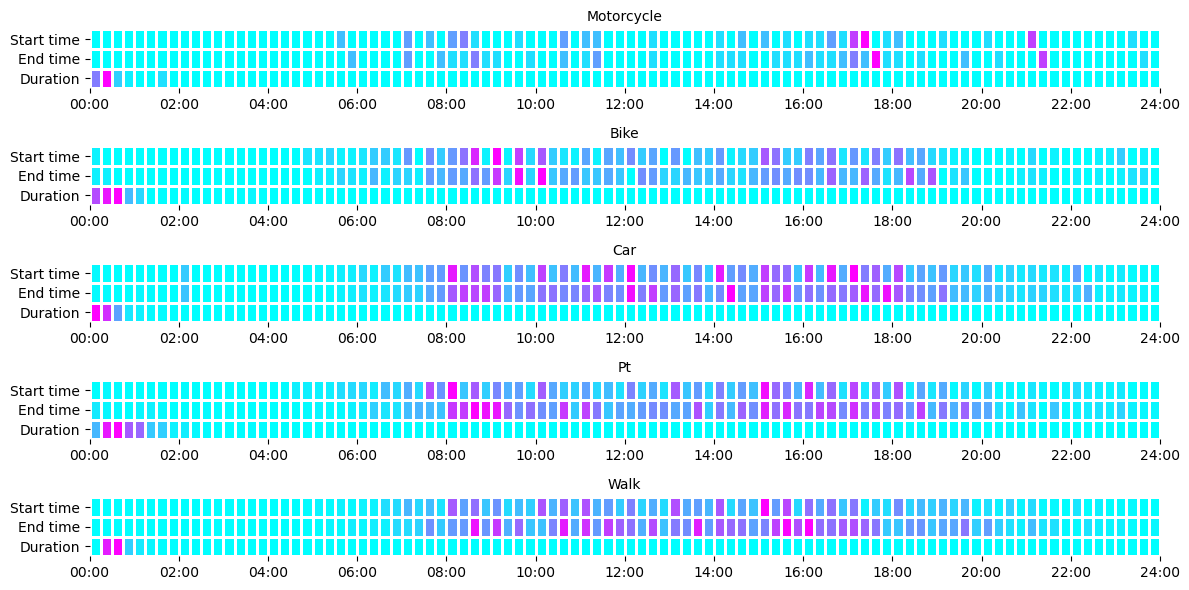

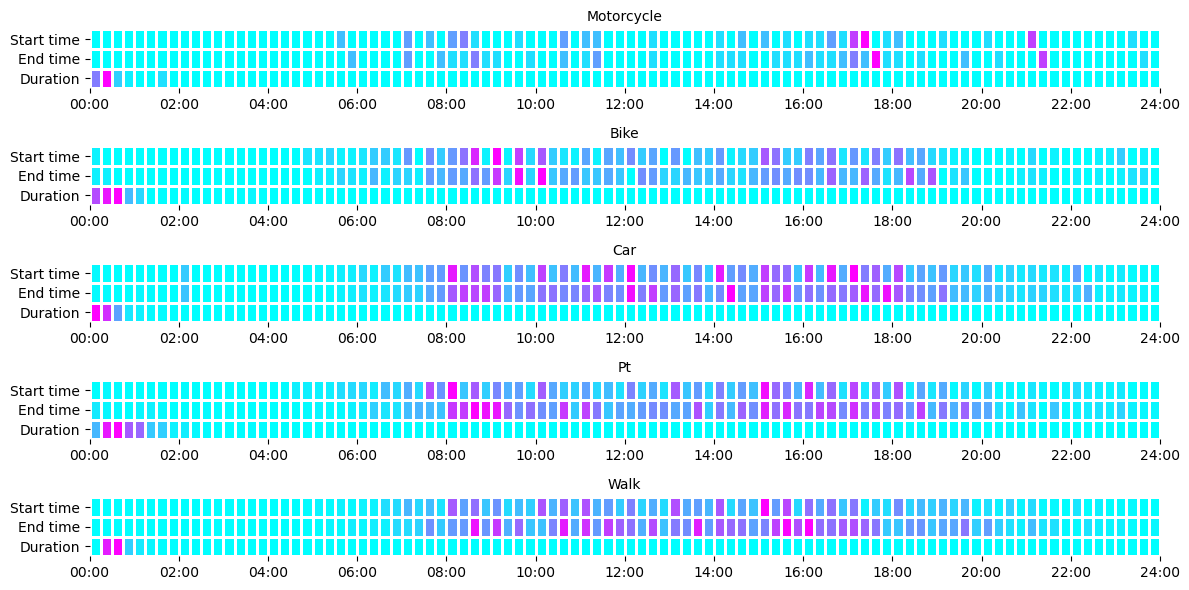

In [371]:
plot_leg_times(population)

In [377]:
plans_iterator = population.plans()

# Initialize a list to store the first 5 plans
first_five_plans = []

# Iterate over the first 5 plans and print them
for i in range(5):
    try:
        plan = next(plans_iterator)
        first_five_plans.append(plan)
        print(f"Plan {i+1}: {plan}")
    except StopIteration:
        print("No more plans available.")
        break

Plan 1: <pam.activity.Plan object at 0x722eb07781d0>
Plan 2: <pam.activity.Plan object at 0x722eb07782d0>
Plan 3: <pam.activity.Plan object at 0x722eb07783d0>
Plan 4: <pam.activity.Plan object at 0x722eb07780d0>
Plan 5: <pam.activity.Plan object at 0x722eb07785d0>


In [405]:
import random 
# Get the iterator for plans
plans_iterator = population.plans()
all_plans = list(plans_iterator)


random_plan = random.choice(all_plans)
print(f"Random Plan: {random_plan}")

Random Plan: <pam.activity.Plan object at 0x722eb05f2e90>


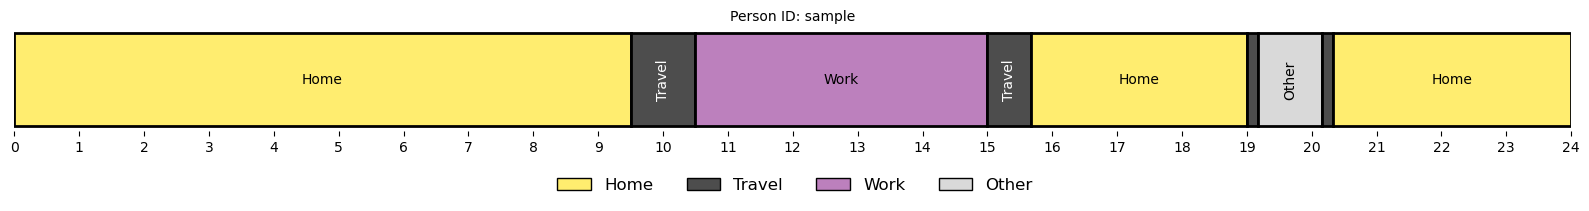

In [406]:
random_plan.plot()

In [409]:
def print_activity_locs(plan):
    summary = PrettyTable(["seq", "purpose",  "location"])
    for seq, act in enumerate(plan.activities):
        summary.add_row([seq, act.act, act.location.area])
    print(summary)


print("Work locations and travel modes:")
print_activity_locs(random_plan)

Work locations and travel modes:
+-----+---------+-----------+
| seq | purpose |  location |
+-----+---------+-----------+
|  0  |   home  | E00057147 |
|  1  |   work  | E00056774 |
|  2  |   home  | E00057147 |
|  3  |  other  |    None   |
|  4  |   home  | E00057147 |
+-----+---------+-----------+


## Load in travel time matrices

In [385]:
travel_times = pd.read_parquet(
    acbm.root_path / "data/external/travel_times/oa/travel_time_matrix_acbm.parquet"
)

travel_times

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination
0,53507,53507,0,0.0,0.0,pt_wkday_morning
1,53507,53508,24,29.0,34.0,pt_wkday_morning
2,53507,53509,17,22.0,27.0,pt_wkday_morning
3,53507,53510,12,14.0,16.0,pt_wkday_morning
4,53507,53511,14,16.0,18.0,pt_wkday_morning
...,...,...,...,...,...,...
36424170,175164,175158,52,52.0,52.0,cycle
36424171,175164,175160,13,13.0,13.0,cycle
36424172,175164,175161,90,90.0,90.0,cycle
36424173,175164,175163,15,15.0,15.0,cycle


## Add OA21CD

In [386]:
# convert from_id and to_id to int to match the boundaries data type
travel_times = travel_times.astype({"from_id": int, "to_id": int})

# merge travel_times with boundaries
travel_times = travel_times.merge(
    boundaries[["OBJECTID", "OA21CD"]],
    left_on="from_id",
    right_on="OBJECTID",
    how="left",
)
travel_times = travel_times.drop(columns="OBJECTID")

travel_times = travel_times.merge(
    boundaries[["OBJECTID", "OA21CD"]],
    left_on="to_id",
    right_on="OBJECTID",
    how="left",
    suffixes=("_from", "_to"),
)
travel_times = travel_times.drop(columns="OBJECTID")

In [387]:
travel_times

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination,OA21CD_from,OA21CD_to
0,53507,53507,0,0.0,0.0,pt_wkday_morning,E00056750,E00056750
1,53507,53508,24,29.0,34.0,pt_wkday_morning,E00056750,E00056751
2,53507,53509,17,22.0,27.0,pt_wkday_morning,E00056750,E00056752
3,53507,53510,12,14.0,16.0,pt_wkday_morning,E00056750,E00056753
4,53507,53511,14,16.0,18.0,pt_wkday_morning,E00056750,E00056754
...,...,...,...,...,...,...,...,...
36424170,175164,175158,52,52.0,52.0,cycle,E00187153,E00187147
36424171,175164,175160,13,13.0,13.0,cycle,E00187153,E00187149
36424172,175164,175161,90,90.0,90.0,cycle,E00187153,E00187150
36424173,175164,175163,15,15.0,15.0,cycle,E00187153,E00187152


In [413]:
# Extract unique zone labels
zone_labels = pd.unique(travel_times[['OA21CD_from', 'OA21CD_to']].values.ravel('K'))
zone_labels


array(['E00056750', 'E00056751', 'E00056752', ..., 'E00187151',
       'E00187152', 'E00187153'], dtype=object)

In [419]:
# Initialize dictionaries to hold OD matrices for each combination type
combination_types = travel_times['combination'].unique()
od_matrices = {comb: np.zeros((len(zone_labels), len(zone_labels))) for comb in combination_types}
od_matrices

{'pt_wkday_morning': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'pt_wkday_afternoon': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'pt_wkday_evening': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'pt_wkday_night': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
# Create a mapping from zone labels to indices
zone_index = {label: idx for idx, label in enumerate(zone_labels)}
zone_index


In [422]:
# Vectorized operation to populate OD matrices
from_indices = travel_times['OA21CD_from'].map(zone_index)
to_indices = travel_times['OA21CD_to'].map(zone_index)

for combination in combination_types:
    print(f"Starting combination: {combination}")
    mask = travel_times['combination'] == combination
    od_matrices[combination][from_indices[mask], to_indices[mask]] = travel_times[mask]['travel_time_p50']
    print(f"Finished combination: {combination}")


Starting combination: pt_wkday_morning
Finished combination: pt_wkday_morning
Starting combination: pt_wkday_afternoon
Finished combination: pt_wkday_afternoon
Starting combination: pt_wkday_evening
Finished combination: pt_wkday_evening
Starting combination: pt_wkday_night
Finished combination: pt_wkday_night
Starting combination: pt_wkend_morning
Finished combination: pt_wkend_morning
Starting combination: pt_wkend_evening
Finished combination: pt_wkend_evening
Starting combination: car
Finished combination: car
Starting combination: walk
Finished combination: walk
Starting combination: cycle
Finished combination: cycle


In [423]:
# Create ODMatrix instances
od_matrix_instances = [
    ODMatrix("time", comb, zone_labels, zone_labels, od_matrices[comb])
    for comb in combination_types
]

In [429]:
od_matrix_instances

[ODMatrix(var='time', mode='pt_wkday_morning', origin_zones=array(['E00056750', 'E00056751', 'E00056752', ..., 'E00187151',
        'E00187152', 'E00187153'], dtype=object), destination_zones=array(['E00056750', 'E00056751', 'E00056752', ..., 'E00187151',
        'E00187152', 'E00187153'], dtype=object), matrix=array([[ 0., 29., 22., ..., 42., 64., 73.],
        [35.,  0., 38., ..., 43., 65., 74.],
        [24., 27.,  0., ..., 42., 64., 73.],
        ...,
        [46., 65., 62., ...,  0., 80., 85.],
        [57., 71., 65., ..., 80.,  0., 24.],
        [76., 76., 75., ..., 99., 24.,  0.]])),
 ODMatrix(var='time', mode='pt_wkday_afternoon', origin_zones=array(['E00056750', 'E00056751', 'E00056752', ..., 'E00187151',
        'E00187152', 'E00187153'], dtype=object), destination_zones=array(['E00056750', 'E00056751', 'E00056752', ..., 'E00187151',
        'E00187152', 'E00187153'], dtype=object), matrix=array([[ 0., 32., 25., ..., 42., 64., 74.],
        [42.,  0., 36., ..., 69., 71., 76.]

In [427]:
# Create the final data structure using ODFactory
od = ODFactory.from_matrices(od_matrix_instances)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()